In [1]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [2]:
df=pd.read_csv('plus.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  3285 non-null   object 
 1   review        3285 non-null   object 
 2   score         3285 non-null   object 
 3   real_date     3285 non-null   object 
 4   year          3285 non-null   float64
 5   month         3285 non-null   float64
 6   type          2969 non-null   object 
 7   dataset       3219 non-null   object 
dtypes: float64(2), object(6)
memory usage: 205.4+ KB


C:\Users\jenny\AppData\Local\Temp/ipykernel_25964/811265187.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('plus.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


In [3]:
df['type'].unique()

array([' 커플', nan, ' 가족', ' 비지니스', ' 개인', ' 친구'], dtype=object)

In [4]:
for i in range(len(df)):
    if df.iloc[i,6] in [' 친구',' 가족',' 커플']:
        df.iloc[i,6] = 'no_solo'
    elif df.iloc[i,6] in [' 비지니스', np.NaN]:
        df.iloc[i,6] = np.NaN
    elif df.iloc[i,6] in [' 개인']:
        df.iloc[i,6]='solo'

In [5]:
df['type'].unique()

array(['no_solo', nan, 'solo'], dtype=object)

In [6]:
df.dropna(subset=['type'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 0 to 3283
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  2612 non-null   object 
 1   review        2612 non-null   object 
 2   score         2612 non-null   object 
 3   real_date     2612 non-null   object 
 4   year          2612 non-null   float64
 5   month         2612 non-null   float64
 6   type          2612 non-null   object 
 7   dataset       2555 non-null   object 
dtypes: float64(2), object(6)
memory usage: 183.7+ KB


In [7]:
#솔로/비솔로 데이터 구분
#비솔로
condition = (df.type=='no_solo')
df2=df.loc[condition]

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1814 entries, 0 to 3279
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  1814 non-null   object 
 1   review        1814 non-null   object 
 2   score         1814 non-null   object 
 3   real_date     1814 non-null   object 
 4   year          1814 non-null   float64
 5   month         1814 non-null   float64
 6   type          1814 non-null   object 
 7   dataset       1772 non-null   object 
dtypes: float64(2), object(6)
memory usage: 127.5+ KB


In [9]:
df2.dropna(subset=['dataset'], how='any', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1772 entries, 0 to 3279
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  1772 non-null   object 
 1   review        1772 non-null   object 
 2   score         1772 non-null   object 
 3   real_date     1772 non-null   object 
 4   year          1772 non-null   float64
 5   month         1772 non-null   float64
 6   type          1772 non-null   object 
 7   dataset       1772 non-null   object 
dtypes: float64(2), object(6)
memory usage: 124.6+ KB


C:\Users\jenny\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
#응집도 계산 전 사용할 토크나이저 함수 정의

import konlpy
stop_list=['우리','함께','있습니다']
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and not pos =='Punctuation' and not pos =='Foreign' and len(word) > 1 and word not in stop_list :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [11]:
#솔로 데이터 토큰화
tokenized_list_no = []
a=df2['dataset'].values
for text in range(len(a)):
    tokenized_list_no.append(tokenize_korean_text(a[text]))

In [12]:
#솔로
model = tp.DMRModel(k=20, alpha=0.1, eta=0.01, min_cf=9,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_no


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 

Total docs: 1772
Total words: 38394
Vocab size: 791


In [13]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 1772 docs, 38394 words
| Total Vocabs: 5778, Used Vocabs: 791
| Entropy of words: 5.94025
| Entropy of term-weighted words: 6.35030
| Removed Vocabs: 지하철 서울 있는
| Metadata of docs and its distribution
|  5: 1149
|  3: 116
|  4: 487
|  2: 14
|  1: 6
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -9.43769
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 9 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal dist

==== Coherence : c ====
Average: 0.4998519929870964 
Per Topic: [0.39398908615112305, 0.5738272964954376, 0.42821288853883743, 0.4669750019907951, 0.4979090541601181, 0.5277079664170742, 0.4971529930830002, 0.5520528823137283, 0.4925638474524021, 0.4851232372224331, 0.4699787274003029, 0.5513226568698884, 0.4649243697524071, 0.5354304902255536, 0.5743974626064301, 0.5146354295313358, 0.5270921602845192, 0.5588368058204651, 0.43273707032203673, 0.45217043310403826]


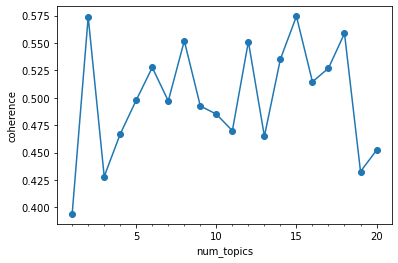

In [14]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

위 결과에서 14개일 때 가장 높은 응집도를 보였기 때문에 토픽을 14개로 설정하였다.

In [15]:
#토픽수 정하고 솔로 분석
model = tp.DMRModel(k=5, alpha=0.1, eta=0.01, min_cf=9,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_no

for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass

model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 1772
Total words: 38394
Vocab size: 791
Topic #0	계단, 엘리베이터, 에스컬레이터, 부산, ktx, 유모차, 예약, 좌석, 걸어서, 아이
Topic #1	이용, 환승, 호선, 너무, 좋아요, 우리나라, KTX, 어디, 최고, 나라
Topic #2	메트로, 시간, 이용, 되어, 세계, 대중교통, 나라, 호선, 환승, 최고
Topic #3	중국어, 기차, 연결, 영어, 아주, 지역, 호텔, 발표, 일본어, 추가
Topic #4	사용, 카드, 쉽게, 시스템, 여행, 매우, 가장, 방법, 좋은, 저렴한


In [16]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 1772 docs, 38394 words
| Total Vocabs: 5778, Used Vocabs: 791
| Entropy of words: 5.94025
| Entropy of term-weighted words: 6.35030
| Removed Vocabs: 지하철 서울 있는
| Metadata of docs and its distribution
|  5: 1149
|  3: 116
|  4: 487
|  2: 14
|  1: 6
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -6.36549
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 9 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 5 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal dis

In [17]:
#솔로 감성점수 계산
print('Topic distributions by score, solo')

df4=pd.DataFrame()
score_labels=['1','2','3','4','5']

for i in score_labels:
    df4[i+'score']=model.get_topic_prior(i)
df4['total']=df4.sum(axis=1)

total_sum=df4['total'].values
gamsung_sum=0
gamsung_list=[]

for i in range(model.k):
    a=df4.iloc[i,:-1].values
    gamsung_sum=(a[0]*1+a[1]*2+a[2]*3+a[3]*4+a[4]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df4['re_score']=gamsung_list
df4.head(20)

Topic distributions by score, solo


,1score,2score,3score,4score,5score,total,re_score
0,0.077023,0.148723,0.043027,0.059459,0.066344,0.394576,2.719643
1,0.007405,0.133168,0.870371,0.163427,0.038461,1.212832,3.076162
2,0.038156,0.959896,0.027817,0.122240,0.147590,1.295699,2.522430
3,0.050258,0.062276,0.668430,0.082611,0.224352,1.087927,3.338739
4,0.025483,0.048896,0.123672,0.849471,1.172580,2.220102,4.393976


In [18]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df4['word_list']=word_list
df4.head(15)

,1score,2score,3score,4score,5score,total,re_score,word_list
0,0.077023,0.148723,0.043027,0.059459,0.066344,0.394576,2.719643,"[계단, 엘리베이터, 에스컬레이터, 부산, ktx, 유모차, 예약, 좌석, 걸어서,..."
1,0.007405,0.133168,0.870371,0.163427,0.038461,1.212832,3.076162,"[이용, 환승, 호선, 너무, 좋아요, 우리나라, KTX, 어디, 최고, 나라]"
2,0.038156,0.959896,0.027817,0.122240,0.147590,1.295699,2.522430,"[메트로, 시간, 이용, 되어, 세계, 대중교통, 나라, 호선, 환승, 최고]"
3,0.050258,0.062276,0.668430,0.082611,0.224352,1.087927,3.338739,"[중국어, 기차, 연결, 영어, 아주, 지역, 호텔, 발표, 일본어, 추가]"
4,0.025483,0.048896,0.123672,0.849471,1.172580,2.220102,4.393976,"[사용, 카드, 쉽게, 시스템, 여행, 매우, 가장, 방법, 좋은, 저렴한]"


In [19]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 또는, 좌석, 다리, 에스컬레이터, 경우
계단	0.03782607614994049
엘리베이터	0.035908933728933334
에스컬레이터	0.03517390042543411
부산	0.02837999537587166
ktx	0.024029675871133804
유모차	0.02031763270497322
예약	0.019525516778230667
좌석	0.018892988562583923
걸어서	0.014222858473658562
아이	0.013561696745455265

== Topic #1 ==
Labels: 환승, 좋아요, 출퇴근, 그래도, 곳곳
이용	0.02413872815668583
환승	0.02410893701016903
호선	0.023459937423467636
너무	0.022428302094340324
좋아요	0.019315721467137337
우리나라	0.017281105741858482
KTX	0.014584268443286419
어디	0.013754761777818203
최고	0.013412063010036945
나라	0.012838339433073997

== Topic #2 ==
Labels: 출퇴근, 같네요, 호선, 시간, 출퇴근 시간
메트로	0.019736679270863533
시간	0.01688399538397789
이용	0.015311561524868011
되어	0.014519231393933296
세계	0.01386252511292696
대중교통	0.01317600067704916
나라	0.012006103061139584
호선	0.0118887173011899
환승	0.01181037537753582
최고	0.011756816878914833

== Topic #3 ==
Labels: 기차, 영어, 또는, 정거장, 하지
중국어	0.01583152823150158
기차	0.014498583041131496
연결	0.014357030391693115
영어	0.0143282357603

In [20]:
#빈도 구하기 전
df5=pd.DataFrame()
df5['docs']=tokenized_list_no
df5['score']=df2['score'].values
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    1772 non-null   object
 1   score   1772 non-null   object
dtypes: object(2)
memory usage: 27.8+ KB


In [21]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)
df5['topic_num']=topic_num
df5[df5['topic_num'].isnull()]

,docs,score,topic_num
3,"[KTX, 정차, 개선, 필요하다, 서울, 용산, 광주, 송정, 구간, 자주, 이용...",3,NaN
4,"[시간, 빠른, 깨끗하고, 무료, 와이파이, 예약, 3일, 코레일, 패스, 가공, ...",5,NaN
6,"[빠른, 깨끗하고, 상당히, 가격, 했습니다, 일반, 갱도, 빨리, 거리, 시간, ...",4,NaN
11,"[코레일, ktx, 전달, 사람, 다른, 나라, 코레일, 체크, 1일, 패스, 있느...",5,NaN
12,"[좌석, 예약, 필요, Ktx, 레일, 패스, 사용, 하지, 않은, 일본, jr, ...",3,NaN
...,...,...,...
1752,"[편리, 외국, 여행, 다니며, 많은, 지하철, 이용, 보았지만, 서울, 지하철, ...",5,NaN
1753,"[서울, 여행, srt, 수서역, 선릉, 있는, 호텔, 숙박, 강남역, 젊은, 청춘...",5,NaN
1755,"[충무로역, 개선, 건의, 호선, 충무로역, 외국인, 많이, 이용, 하던데, 승차권...",5,NaN
1760,"[한국, 지하철, 원더풀, 그냥, 해외, 있다, 돌아오니, 그냥, 한국, 지하철, ...",4,NaN


In [22]:
df6=df5.groupby(['topic_num','score'])['docs']
print(df6.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     2       1
1         0.0     3       3
2         0.0     4       3
3         0.0     5       6
4         1.0     1       1
5         1.0     3      20
6         1.0     4      47
7         1.0     5      85
8         2.0     2       1
9         2.0     3      16
10        2.0     4      30
11        2.0     5      98
12        3.0     3       3
13        3.0     4       5
14        3.0     5      18
15        4.0     1       5
16        4.0     2      12
17        4.0     3      61
18        4.0     4     363
19        4.0     5     872
